# Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pyswarms as ps
import glob
import os
import importlib
import matplotlib.animation as animation

from scipy.io import mmread
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from pyswarms.utils.plotters.formatters import Mesher, Designer
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
from pyswarms.utils.functions import single_obj as fx
from functools import partial
from IPython.display import HTML

import src.SI as SI
importlib.reload(SI)

<module 'src.pbmc3k_SI' from 'c:\\Users\\Victo\\Desktop\\University\\2024-25\\BDA-project\\notebooks\\src\\pbmc3k_SI.py'>

# Import data

In [11]:
data_DiCA = pd.read_csv('data/speeches/DiCA_encoding.csv', index_col=0)
data_AUTOENC = pd.read_csv('data/speeches/AUTOENC_encoding.csv', index_col=0)
data_AUTOENC = data_AUTOENC.drop(columns=['X'])

In [12]:
data_DiCA.head()

,fileID,Dim1,Dim2,lang4
1,EN_NL_273,-0.294789,0.386800,Eng_Dut
2,EN_NL_274,-1.114812,0.548017,Eng_Dut
3,EN_NL_275,0.129165,-0.005245,Eng_Dut
4,EN_NL_276,0.000329,0.378454,Eng_Dut
5,EN_NL_277,-0.062971,0.350621,Eng_Dut


In [13]:
data_AUTOENC.head()

,Dim1,Dim2,fileID,lang4
1,-0.119105,0.055789,EN_NL_273,Eng_Dut
2,-0.119105,0.055789,EN_NL_274,Eng_Dut
3,-0.108587,-0.115267,EN_NL_275,Eng_Dut
4,-0.119105,0.055789,EN_NL_276,Eng_Dut
5,-0.119105,0.055789,EN_NL_277,Eng_Dut


# Old Analysis

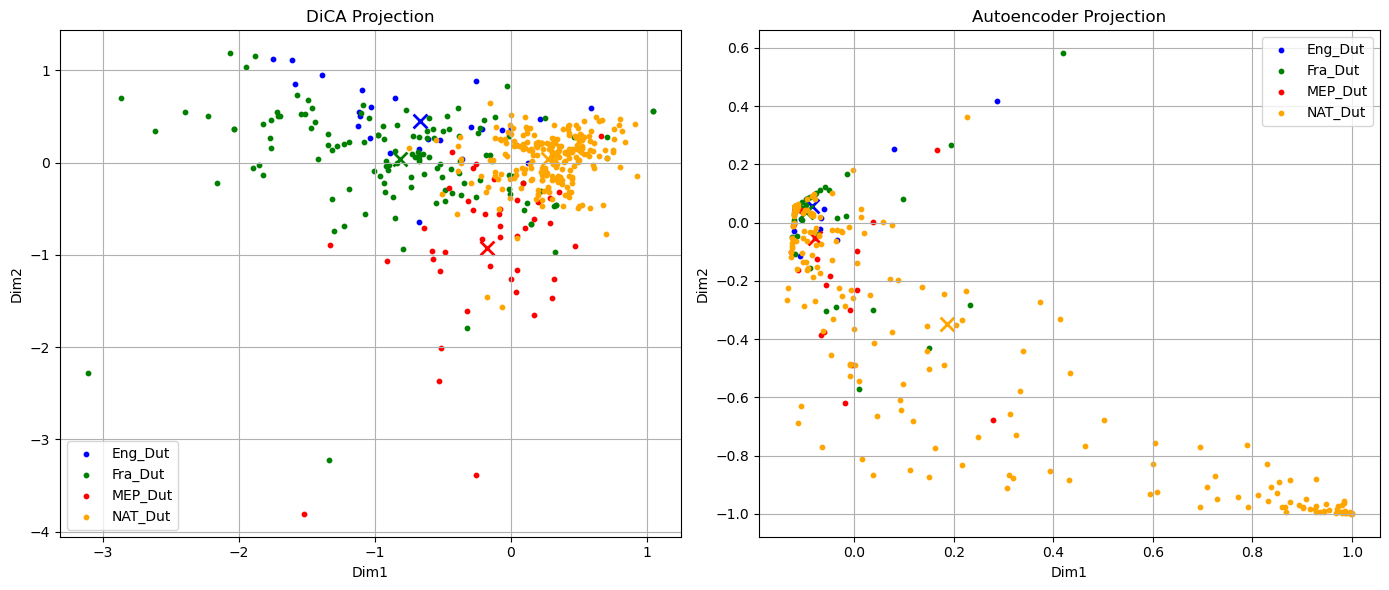

In [27]:
# Define color palette (adjust if you have more than 6 language groups)
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot for data_DiCA ---
groups_DiCA = data_DiCA.groupby('lang4')
for i, (name, group) in enumerate(groups_DiCA):
    axs[0].scatter(group['Dim1'], group['Dim2'], 
                   s=10, 
                   color=colors[i % len(colors)], 
                   label=name)
    
    # Centroid
    centroid_x = group['Dim1'].mean()
    centroid_y = group['Dim2'].mean()
    axs[0].scatter(centroid_x, centroid_y, 
                   color=colors[i % len(colors)], 
                   marker='x', s=100, linewidths=2)

axs[0].set_title('DiCA Projection')
axs[0].set_xlabel('Dim1')
axs[0].set_ylabel('Dim2')
axs[0].legend()
axs[0].grid(True)

# --- Plot for data_AUTOENC ---
groups_AUTOENC = data_AUTOENC.groupby('lang4')
for i, (name, group) in enumerate(groups_AUTOENC):
    axs[1].scatter(group['Dim1'], group['Dim2'], 
                   s=10, 
                   color=colors[i % len(colors)], 
                   label=name)
    
    # Centroid
    centroid_x = group['Dim1'].mean()
    centroid_y = group['Dim2'].mean()
    axs[1].scatter(centroid_x, centroid_y, 
                   color=colors[i % len(colors)], 
                   marker='x', s=100, linewidths=2)

axs[1].set_title('Autoencoder Projection')
axs[1].set_xlabel('Dim1')
axs[1].set_ylabel('Dim2')
axs[1].legend()
axs[1].grid(True)

# Tight layout and show
plt.tight_layout()
plt.show()

In [ ]:
results_DiCA = {}
results_AUTOENC = {}  

c:\Users\Victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Victo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


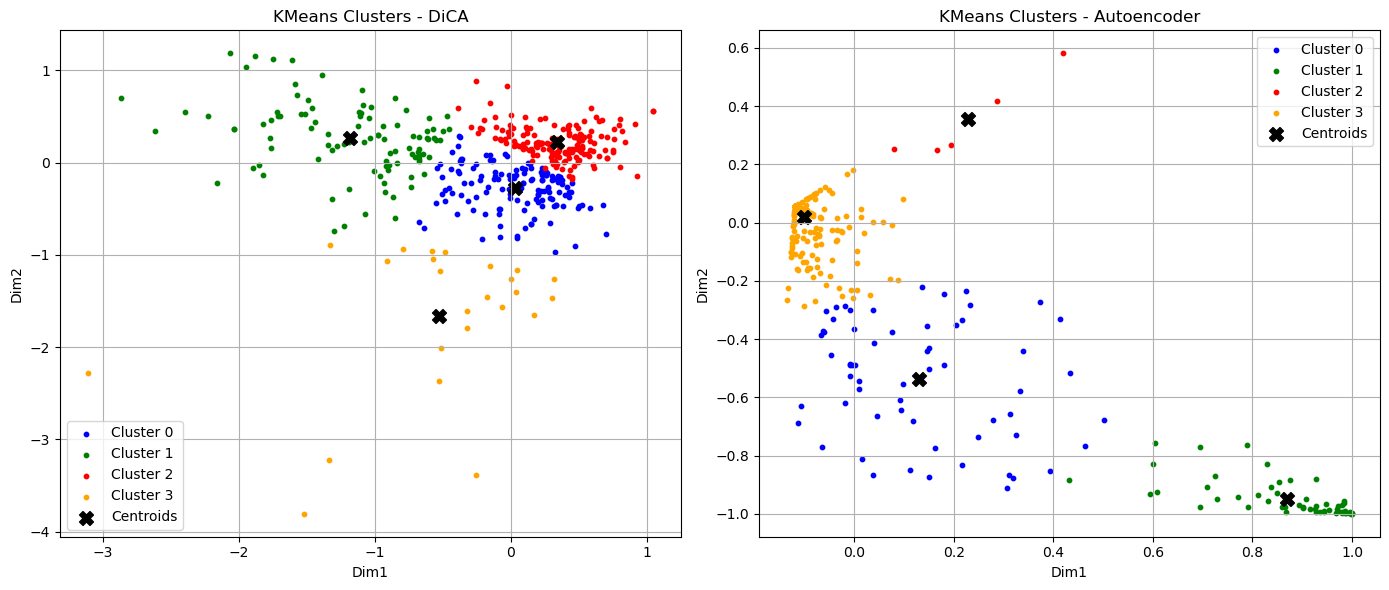

In [49]:
# Number of clusters (adjust as needed)
n_clusters = 4

# Fit KMeans on DiCA
kmeans_DiCA = KMeans(n_clusters=n_clusters, random_state=42)
data_DiCA['kmeans_cluster'] = kmeans_DiCA.fit_predict(data_DiCA[['Dim1', 'Dim2']])

# Fit KMeans on AUTOENC
kmeans_AUTOENC = KMeans(n_clusters=n_clusters, random_state=42)
data_AUTOENC['kmeans_cluster'] = kmeans_AUTOENC.fit_predict(data_AUTOENC[['Dim1', 'Dim2']])

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Define a colormap (you can also use plt.cm.get_cmap if you prefer)
cluster_colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']

# --- KMeans on data_DiCA ---
for i in range(n_clusters):
    cluster = data_DiCA[data_DiCA['kmeans_cluster'] == i]
    axs[0].scatter(cluster['Dim1'], cluster['Dim2'], 
                   s=10, 
                   color=cluster_colors[i % len(cluster_colors)], 
                   label=f'Cluster {i}')
    
# Centroids
centroids_DiCA = kmeans_DiCA.cluster_centers_
axs[0].scatter(centroids_DiCA[:, 0], centroids_DiCA[:, 1], 
               c='black', marker='X', s=100, label='Centroids')

axs[0].set_title('KMeans Clusters - DiCA')
axs[0].set_xlabel('Dim1')
axs[0].set_ylabel('Dim2')
axs[0].legend()
axs[0].grid(True)

# --- KMeans on data_AUTOENC ---
for i in range(n_clusters):
    cluster = data_AUTOENC[data_AUTOENC['kmeans_cluster'] == i]
    axs[1].scatter(cluster['Dim1'], cluster['Dim2'], 
                   s=10, 
                   color=cluster_colors[i % len(cluster_colors)], 
                   label=f'Cluster {i}')
    
# Centroids
centroids_AUTOENC = kmeans_AUTOENC.cluster_centers_
axs[1].scatter(centroids_AUTOENC[:, 0], centroids_AUTOENC[:, 1], 
               c='black', marker='X', s=100, label='Centroids')

axs[1].set_title('KMeans Clusters - Autoencoder')
axs[1].set_xlabel('Dim1')
axs[1].set_ylabel('Dim2')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

results_DiCA["KMeans"] = {
    "cost": kmeans_DiCA.inertia_,
    "silhouette": silhouette_score(data_DiCA[['Dim1', 'Dim2']], data_DiCA['kmeans_cluster']),
    "centers": kmeans_DiCA.cluster_centers_,
    "labels": data_DiCA['kmeans_cluster'].values
    
}

# Store KMeans results for AUTOENC
 
results_AUTOENC["KMeans"] = {
    "cost": kmeans_AUTOENC.inertia_,
    "silhouette": silhouette_score(data_AUTOENC[['Dim1', 'Dim2']], data_AUTOENC['kmeans_cluster']),
    "centers": kmeans_AUTOENC.cluster_centers_,
    "labels": data_AUTOENC['kmeans_cluster'].values
}


# New Analysis

In [50]:
# Assume tsne_df is a DataFrame with a 'Barcode' column and two t-SNE coordinate columns.
# Convert tsne_df to a numeric array (ignoring the 'Barcode'):
data_DiCA_coords = data_DiCA.drop(columns=["lang4", "fileID"]).values  # shape: (n_cells, 2)
data_AUTOENC_coords = data_AUTOENC.drop(columns=["lang4", "fileID"]).values  # shape: (n_cells, 2)

n_clusters = 4
iters = 100
n_particles = 30

In [51]:
# --- Run PSO on DiCA ---
start = time.time()
pso_cost_DiCA, pso_centers_DiCA, pso_labels_DiCA, pso_sil_DiCA, pso_pos_history_DiCA, pso_cost_history_DiCA = SI.run_pso(
    data_DiCA_coords, n_clusters, iters, n_particles, record_history=True
)
results_DiCA["PSO"] = {
    "cost": pso_cost_DiCA,
    "silhouette": pso_sil_DiCA,
    "centers": pso_centers_DiCA,
    "labels": pso_labels_DiCA,
}
print("PSO run time on DiCA: {:.2f} seconds".format(time.time() - start))

# --- Run PSO on AUTOENC ---
start = time.time()
pso_cost_AUTOENC, pso_centers_AUTOENC, pso_labels_AUTOENC, pso_sil_AUTOENC, pso_pos_history_AUTOENC, pso_cost_history_AUTOENC = SI.run_pso(
    data_AUTOENC_coords, n_clusters, iters, n_particles, record_history=True
)
results_AUTOENC["PSO"] = {
    "cost": pso_cost_AUTOENC,
    "silhouette": pso_sil_AUTOENC,
    "centers": pso_centers_AUTOENC,
    "labels": pso_labels_AUTOENC,
}
print("PSO run time on AUTOENC: {:.2f} seconds".format(time.time() - start))


PSO run time on DiCA: 0.48 seconds
PSO run time on AUTOENC: 0.47 seconds


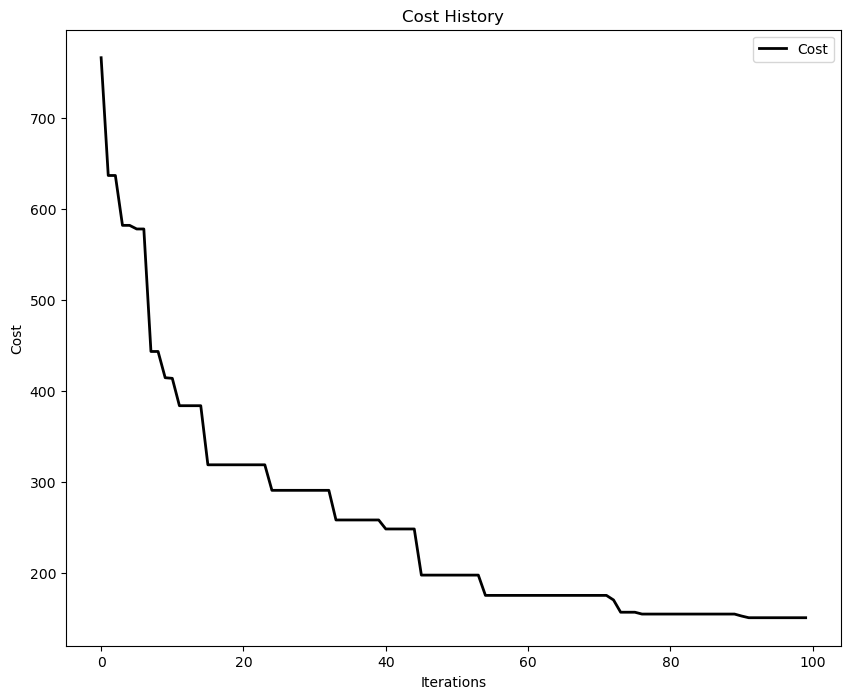

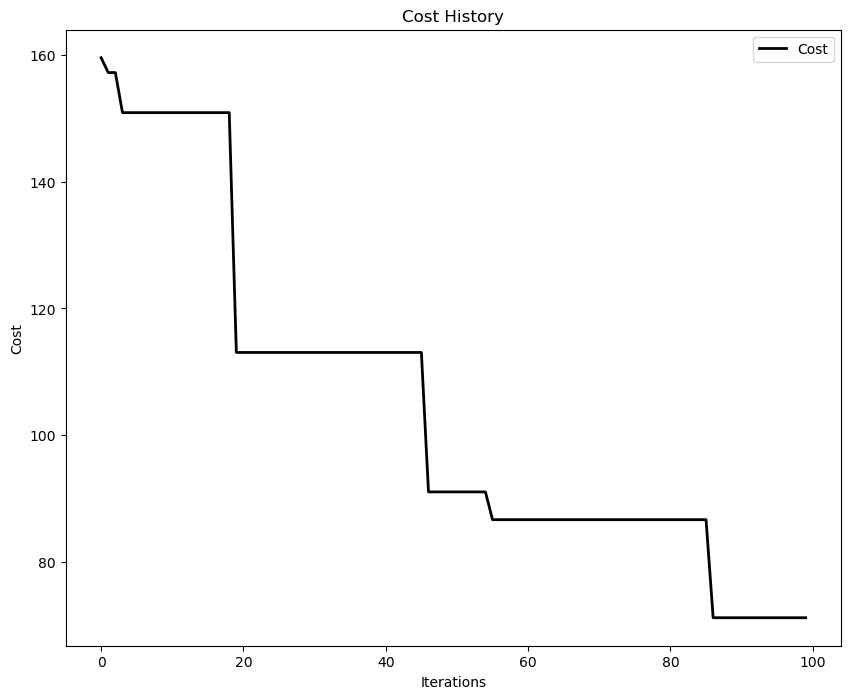

In [52]:
plot_cost_history(cost_history=pso_cost_history_DiCA)
plt.show()
plot_cost_history(cost_history=pso_cost_history_AUTOENC)
plt.show()

In [53]:
# --- ABC and ACOR on DiCA ---
start = time.time()
abc_cost_DiCA, abc_centers_DiCA, abc_labels_DiCA, abc_sil_DiCA, abc_history_DiCA = SI.run_abc(
    data_DiCA_coords, n_clusters, iters, n_food_sources=30, limit=20, record_history=True
)
results_DiCA["ABC"] = {
    "cost": abc_cost_DiCA,
    "silhouette": abc_sil_DiCA,
    "centers": abc_centers_DiCA,
    "labels": abc_labels_DiCA
}
print("ABC run time on DiCA: {:.2f} seconds".format(time.time() - start))

start = time.time()
acor_cost_DiCA, acor_centers_DiCA, acor_labels_DiCA, acor_sil_DiCA, acor_history_DiCA = SI.run_acor(
    data_DiCA_coords, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True
)
results_DiCA["ACOR"] = {
    "cost": acor_cost_DiCA,
    "silhouette": acor_sil_DiCA,
    "centers": acor_centers_DiCA,
    "labels": acor_labels_DiCA
}
print("ACOR run time on DiCA: {:.2f} seconds".format(time.time() - start))


# --- ABC and ACOR on AUTOENC ---
start = time.time()
abc_cost_AUTOENC, abc_centers_AUTOENC, abc_labels_AUTOENC, abc_sil_AUTOENC, abc_history_AUTOENC = SI.run_abc(
    data_AUTOENC_coords, n_clusters, iters, n_food_sources=30, limit=20, record_history=True
)
results_AUTOENC["ABC"] = {
    "cost": abc_cost_AUTOENC,
    "silhouette": abc_sil_AUTOENC,
    "centers": abc_centers_AUTOENC,
    "labels": abc_labels_AUTOENC
}
print("ABC run time on AUTOENC: {:.2f} seconds".format(time.time() - start))

start = time.time()
acor_cost_AUTOENC, acor_centers_AUTOENC, acor_labels_AUTOENC, acor_sil_AUTOENC, acor_history_AUTOENC = SI.run_acor(
    data_AUTOENC_coords, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85, record_history=True
)
results_AUTOENC["ACOR"] = {
    "cost": acor_cost_AUTOENC,
    "silhouette": acor_sil_AUTOENC,
    "centers": acor_centers_AUTOENC,
    "labels": acor_labels_AUTOENC
}
print("ACOR run time on AUTOENC: {:.2f} seconds".format(time.time() - start))


ABC run time on DiCA: 0.55 seconds
ACOR run time on DiCA: 0.60 seconds
ABC run time on AUTOENC: 0.56 seconds
ACOR run time on AUTOENC: 0.62 seconds


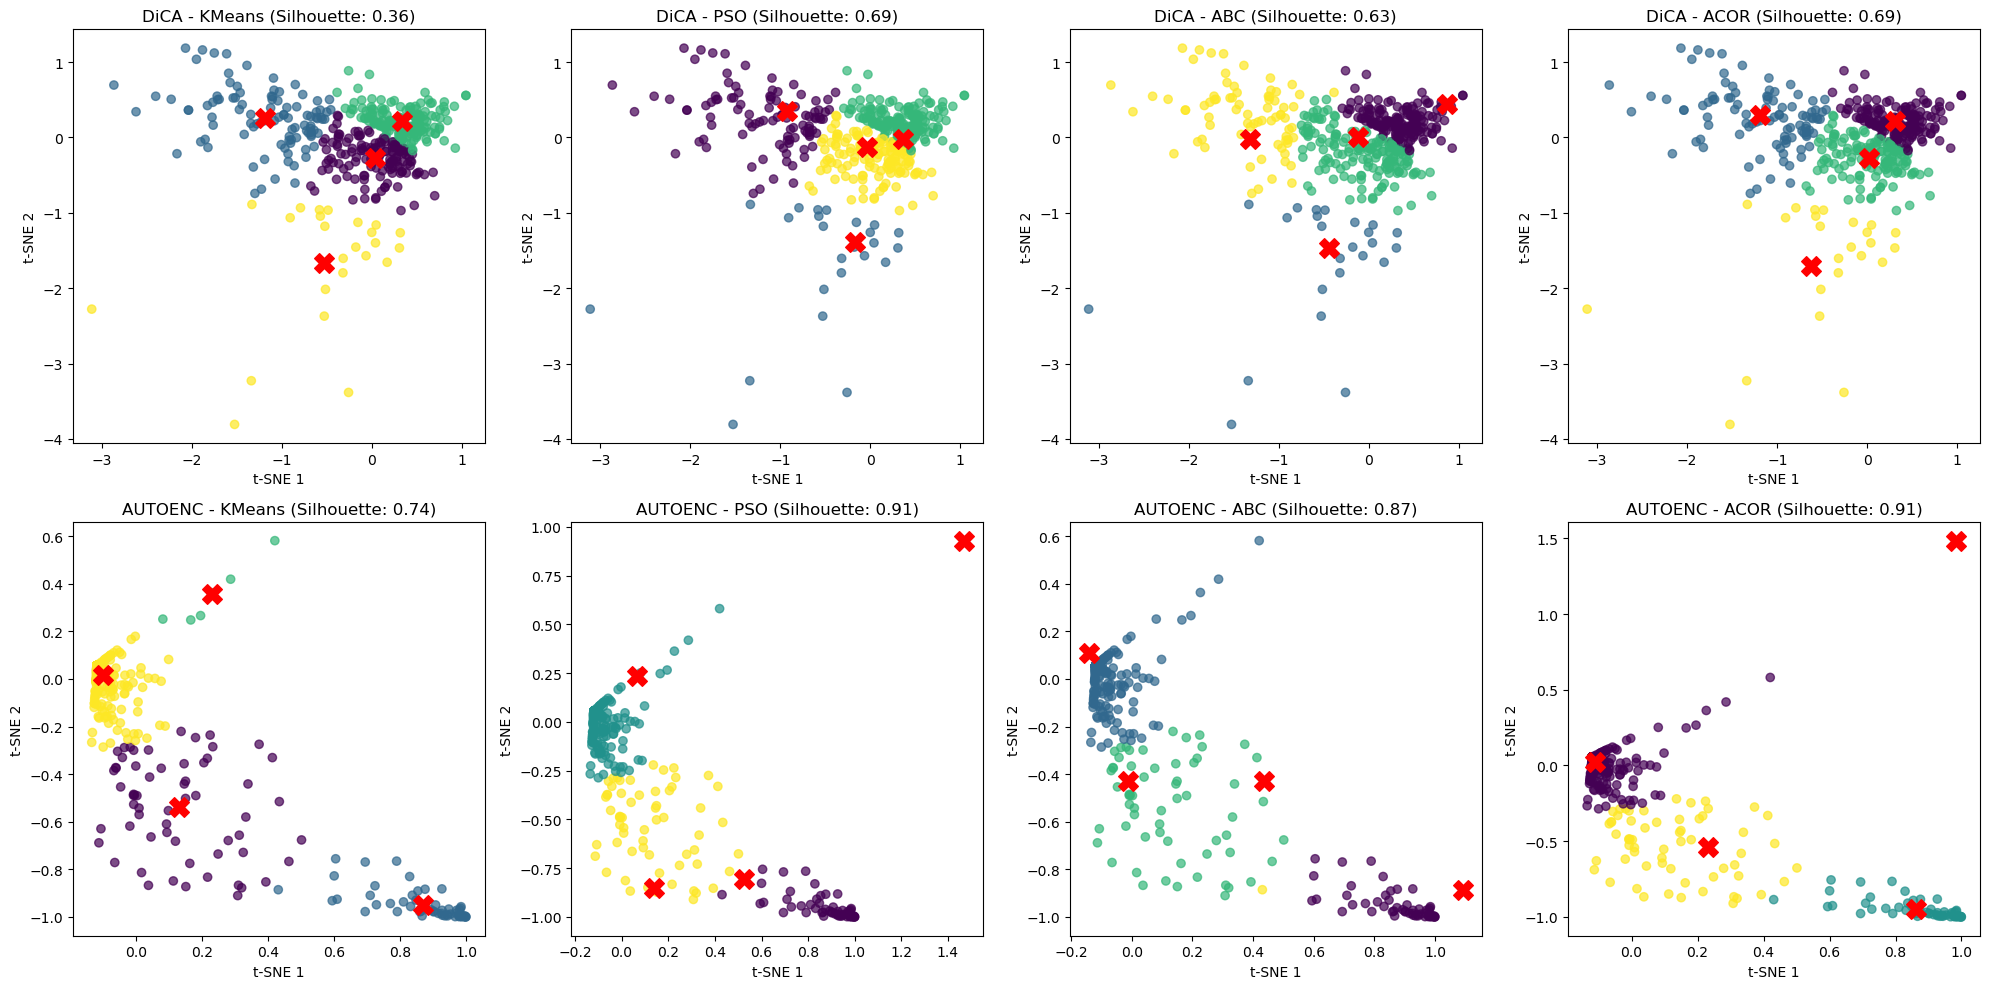

In [54]:
# -------------------------------
# 6. Visualization of Clustering Results - DiCA and AUTOENC
# -------------------------------
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# --- DiCA Results ---
plt.sca(axs[0, 0])
SI.plot_clusters(data_DiCA_coords, results_DiCA["KMeans"]["labels"], results_DiCA["KMeans"]["silhouette"],
                 title="DiCA - KMeans (Silhouette: {:.2f})", centers=results_DiCA["KMeans"]["centers"])

plt.sca(axs[0, 1])
SI.plot_clusters(data_DiCA_coords, results_DiCA["PSO"]["labels"], results_DiCA["PSO"]["silhouette"],
                 title="DiCA - PSO (Silhouette: {:.2f})", centers=results_DiCA["PSO"]["centers"])

plt.sca(axs[0, 2])
SI.plot_clusters(data_DiCA_coords, results_DiCA["ABC"]["labels"], results_DiCA["ABC"]["silhouette"],
                 title="DiCA - ABC (Silhouette: {:.2f})", centers=results_DiCA["ABC"]["centers"])

plt.sca(axs[0, 3])
SI.plot_clusters(data_DiCA_coords, results_DiCA["ACOR"]["labels"], results_DiCA["ACOR"]["silhouette"],
                 title="DiCA - ACOR (Silhouette: {:.2f})", centers=results_DiCA["ACOR"]["centers"])

# --- AUTOENC Results ---
plt.sca(axs[1, 0])
SI.plot_clusters(data_AUTOENC_coords, results_AUTOENC["KMeans"]["labels"], results_AUTOENC["KMeans"]["silhouette"],
                 title="AUTOENC - KMeans (Silhouette: {:.2f})", centers=results_AUTOENC["KMeans"]["centers"])

plt.sca(axs[1, 1])
SI.plot_clusters(data_AUTOENC_coords, results_AUTOENC["PSO"]["labels"], results_AUTOENC["PSO"]["silhouette"],
                 title="AUTOENC - PSO (Silhouette: {:.2f})", centers=results_AUTOENC["PSO"]["centers"])

plt.sca(axs[1, 2])
SI.plot_clusters(data_AUTOENC_coords, results_AUTOENC["ABC"]["labels"], results_AUTOENC["ABC"]["silhouette"],
                 title="AUTOENC - ABC (Silhouette: {:.2f})", centers=results_AUTOENC["ABC"]["centers"])

plt.sca(axs[1, 3])
SI.plot_clusters(data_AUTOENC_coords, results_AUTOENC["ACOR"]["labels"], results_AUTOENC["ACOR"]["silhouette"],
                 title="AUTOENC - ACOR (Silhouette: {:.2f})", centers=results_AUTOENC["ACOR"]["centers"])

plt.tight_layout()
plt.show()



In [57]:
# -------------------------------
# 7. Print Comparison Summary
# -------------------------------
print("Clustering Comparison Results:")
for algo, res in results.items():
    print(f"{algo}: Cost = {res['cost']:.2f}, Silhouette Score = {res['silhouette']:.3f}")


Clustering Comparison Results:
PSO: Cost = 117.64, Silhouette Score = 0.692


In [ ]:
pd.DataFrame(results).T.to_csv("../results/pbmc3k/clustering_results.csv", index=True)0